In [39]:
import seaborn as sns
colors = sns.color_palette("colorblind", 10)

#Planet periods
planet_periods = [8.24958, 12.4032, 24.1396]
asm_period = 40 #note: plug in the true value here

#Rotation periods (from Sarah Blunt's Lomb-Scargle analysis)
lco_period = 2.9152
k2_periods = [2.8486, 2.6955, 3.0026]
tess_periods = [2.7378, 2.9615, 3.2067]

In [92]:
import numpy as np

rand = np.random.default_rng(42)

per1 = 2.6955; freq1 = 1/per1
per2 = 2.8486; freq2 = 1/per2

beat_freq = abs(freq1-freq2)
beat_per = 1/beat_freq

amp1 = np.random.uniform(0,1)
amp2 = np.random.uniform(0,1)
amp3 = np.random.uniform(0,1)
amp4 = np.random.uniform(0,1)

phi1 = np.random.uniform(0,2*np.pi)
phi2 = np.random.uniform(0,2*np.pi)
phi3 = np.random.uniform(0,2*np.pi)
phi4 = np.random.uniform(0,2*np.pi)

t = np.arange(0, 180.02, 0.02) # Similar to K2

y = amp1 * np.sin(2 * np.pi * freq1 * t + phi1) + amp2 * np.sin(2 * np.pi * 2*freq1 * t + phi2)
y += amp3 * np.sin(2 * np.pi * freq2 * t + phi3) + amp4 * np.sin(2 * np.pi * 2*freq2 * t + phi4)
y /= (amp1+amp2+amp3+amp4)
#y +=  0.1 * rand.standard_normal(len(t))

# Generate synthetic light curve

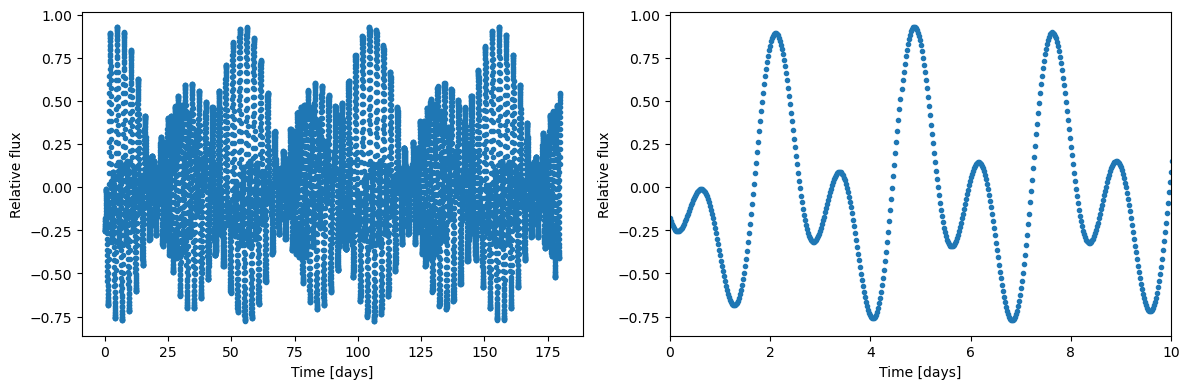

In [93]:
import matplotlib.pyplot as plt 
import matplotlib as mpl
mpl.rcParams["figure.dpi"] = 100


fig,(ax1,ax2)=plt.subplots(nrows=1,ncols=2,figsize=(12,4))

for ax in [ax1,ax2]:
    ax.plot(t, y, '.')
    ax.set_xlabel('Time [days]')
    ax.set_ylabel('Relative flux')
ax2.set_xlim(0,10)
plt.tight_layout()
plt.show()

# That looks fairly realistic.

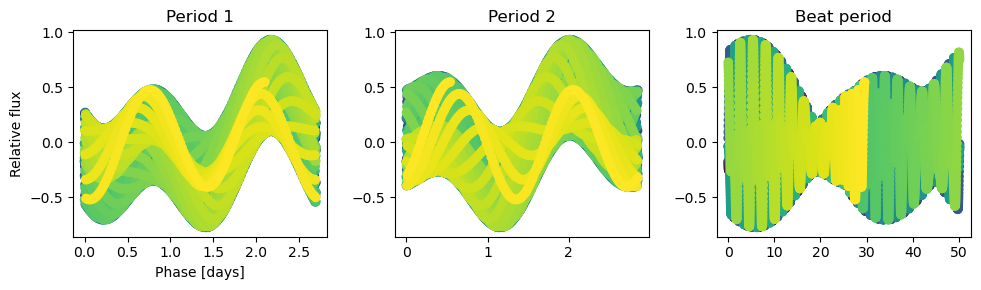

In [94]:
#What do the phase-folded light curves look like?

fig,(ax1,ax2,ax3) = plt.subplots(ncols=3, figsize=(10,3))

ax1.set_ylabel('Relative flux')
ax1.set_xlabel('Phase [days]')
ax1.scatter((t%per1), y, c=t)
ax2.scatter((t%per2), y, c=t)
ax3.scatter((t%beat_per), y, c=t)

ax1.set_title('Period 1')
ax2.set_title('Period 2')
ax3.set_title('Beat period')

plt.tight_layout()
plt.show()

# Lomb-Scargle periodogram (single term)

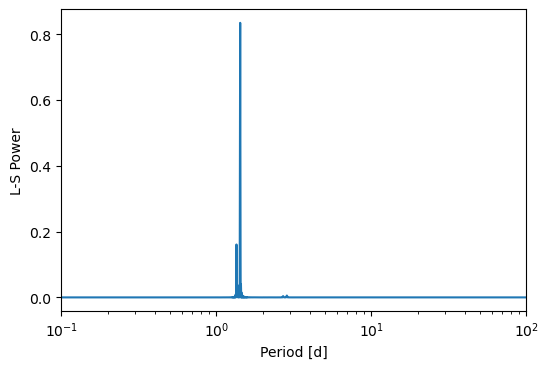

In [58]:
from astropy.timeseries import LombScargle

frequency, power = LombScargle(t, y, nterms=1).autopower(minimum_frequency=1/200,
                                               maximum_frequency=1/0.1,
                                               samples_per_peak=10)
period = 1/frequency

plt.plot(period, power)
plt.xlabel('Period [d]')
plt.ylabel('L-S Power')
plt.semilogx()
plt.xlim(0.1,100)
plt.show()

# Phase the light curve on the top peaks

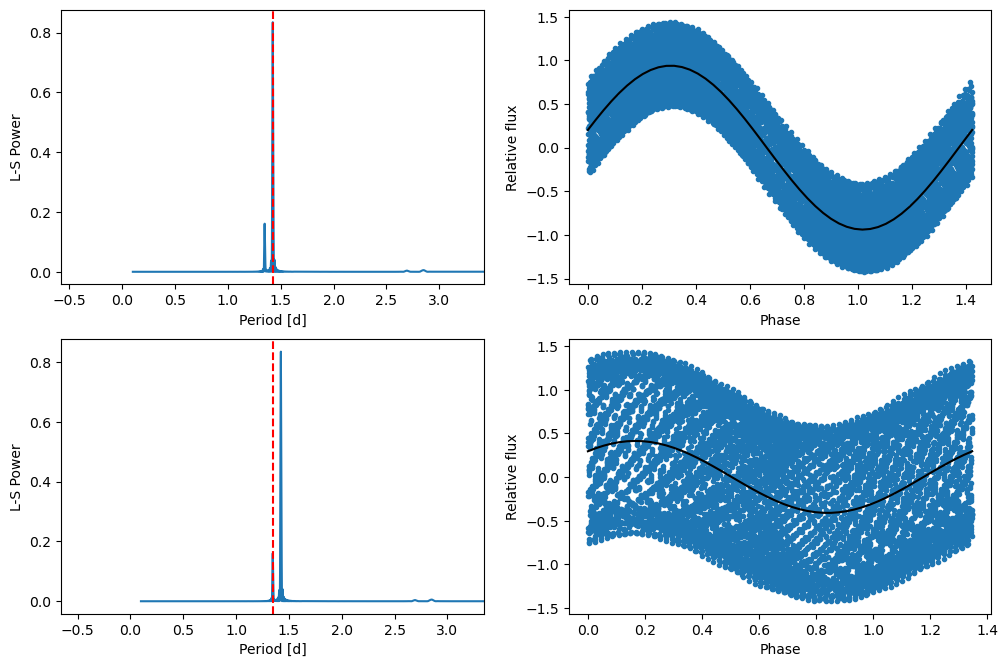

In [59]:
from scipy.signal import find_peaks

peaks, _ = find_peaks(power, distance=5, height=0.1)

fig,axes = plt.subplots(nrows=len(peaks),ncols=2,figsize=(12,4*len(peaks)))

for i,p in enumerate(peaks):
    ax1, ax2 = axes[i][0],axes[i][1]

    ax1.plot(period, power)
    ax1.axvline(period[p], ls='--', color='r')
    ax1.set_xlim(period[p]-2,period[p]+2)
    ax1.set_ylabel('L-S Power')
    ax1.set_xlabel('Period [d]')
    
    
    dy = 0.1
    ls = LombScargle(t, y, dy)

    t_fit = np.linspace(0, period[p])
    y_fit = ls.model(t_fit, 1/period[p])
    
    ax2.plot((t%period[p]), y, '.')
    ax2.plot(t_fit, y_fit, 'k')
    
    ax2.set_ylabel('Relative flux')
    ax2.set_xlabel('Phase')    

plt.show()

# Let's try to fit the simple model to the K2 light curve

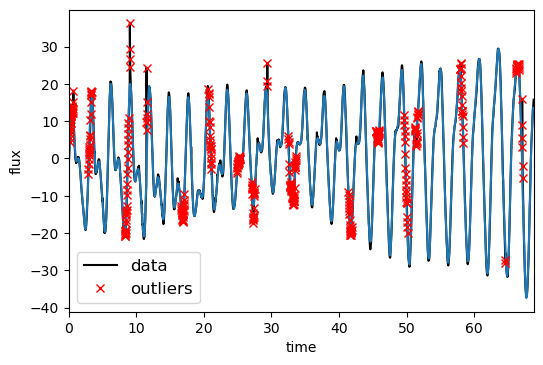

In [95]:
#epic_id = 210818897

from astropy.io import fits
from scipy.signal import savgol_filter

# Download the data
lc_url = "https://archive.stsci.edu/hlsps/everest/v2/c04/210800000/18897/hlsp_everest_k2_llc_210818897-c04_kepler_v2.0_lc.fits"
with fits.open(lc_url) as hdus:
    lc = hdus[1].data
    lc_hdr = hdus[1].header

# Work out the exposure time
texp = lc_hdr["FRAMETIM"] * lc_hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0

# Mask bad data
m = (
    (np.arange(len(lc)) > 100)
    & np.isfinite(lc["FLUX"])
    & np.isfinite(lc["TIME"])
)
bad_bits = [1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 16, 17]
qual = lc["QUALITY"]
for b in bad_bits:
    m &= qual & 2 ** (b - 1) == 0

# Convert to parts per thousand
x = lc["TIME"][m]
y = lc["FLUX"][m]
mu = np.median(y)
y = (y / mu - 1) * 1e3

# Identify outliers
m = np.ones(len(y), dtype=bool)
for i in range(10):
    y_prime = np.interp(x, x[m], y[m])
    smooth = savgol_filter(y_prime, 41, polyorder=3)
    resid = y - smooth
    sigma = np.sqrt(np.mean(resid**2))
    m0 = np.abs(resid) < 3 * sigma
    if m.sum() == m0.sum():
        m = m0
        break
    m = m0

# Discard both positive and negative outliers
m = abs(resid) < 3 * sigma


# Mask the transits as well
d19_per = [8.24958, 12.4032, 24.1396, 60]
d19_t0  = [2231.2797, 2239.3913, 2234.0488, 2263.6229]

for i in range(len(d19_per)):
    _p, _t0 = d19_per[i], d19_t0[i]
    x_fold = (x - _t0 + 0.5 * _p) % _p - 0.5 * _p
    m &= np.abs(x_fold) > 0.25


# Shift the data so that the K2 data start at t=0. This tends to make the fit
# better behaved since t0 covaries with period.
x_ref = np.min(x[m])
x -= x_ref

# Plot the data
plt.plot(x, y, "k", label="data")
plt.plot(x, smooth)
plt.plot(x[~m], y[~m], "xr", label="outliers")
plt.legend(fontsize=12)
plt.xlim(x.min(), x.max())
plt.xlabel("time")
plt.ylabel("flux")

# Make sure that the data type is consistent
x = np.ascontiguousarray(x[m], dtype=np.float64)
y = np.ascontiguousarray(y[m], dtype=np.float64)
smooth = np.ascontiguousarray(smooth[m], dtype=np.float64)

### Periodogram of K2 light curve

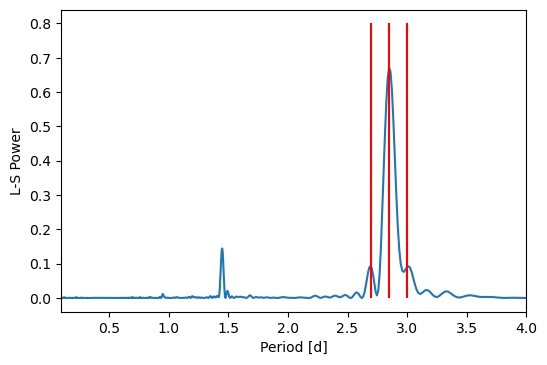

In [96]:
from astropy.timeseries import LombScargle

frequency, power = LombScargle(x, y, nterms=1).autopower(minimum_frequency=1/200,
                                               maximum_frequency=1/0.1,
                                               samples_per_peak=10)
period = 1/frequency

plt.plot(period, power)
plt.vlines(k2_periods, ymin=0, ymax=0.8, color='r')
plt.xlabel('Period [d]')
plt.ylabel('L-S Power')
plt.xlim(0.1,4)
plt.show()

# Phase-fold K2 light curve on the periods around 3 d

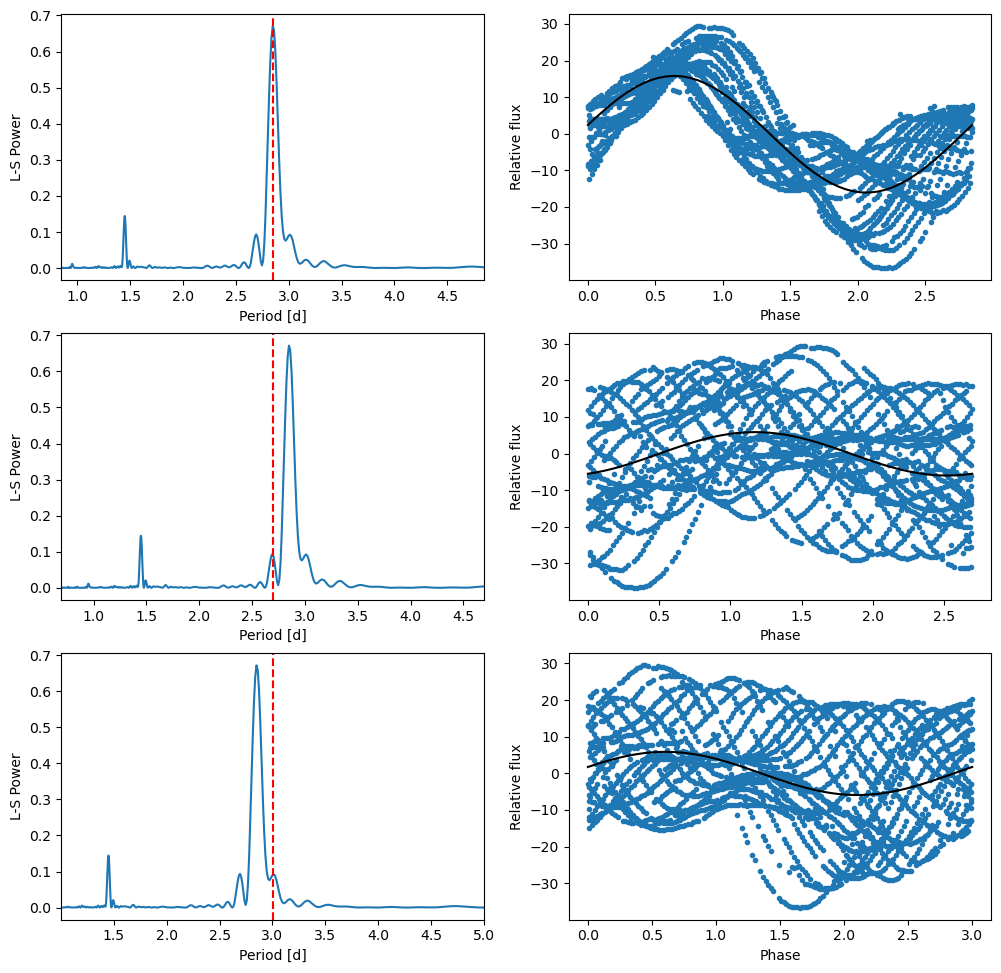

In [97]:
fig,axes = plt.subplots(nrows=len(k2_periods),ncols=2,figsize=(12,4*len(k2_periods)))

for i,p in enumerate(k2_periods):
    ax1, ax2 = axes[i][0],axes[i][1]

    ax1.plot(period, power)
    ax1.axvline(p, ls='--', color='r')
    ax1.set_xlim(p-2,p+2)
    ax1.set_ylabel('L-S Power')
    ax1.set_xlabel('Period [d]')
    
    
    dy = 0.1
    ls = LombScargle(x, y, dy)

    t_fit = np.linspace(0,p)
    y_fit = ls.model(t_fit, 1/p)
    
    ax2.plot((x%p), y, '.')
    ax2.plot(t_fit, y_fit, 'k')
    
    ax2.set_ylabel('Relative flux')
    ax2.set_xlabel('Phase')    

plt.show()

[ 2.88501766  2.97062667 12.1509582   5.          8.510218   -0.5187569
  1.16539881 -0.40965899 -0.55477096  6.44407482]


/Users/tdavid/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


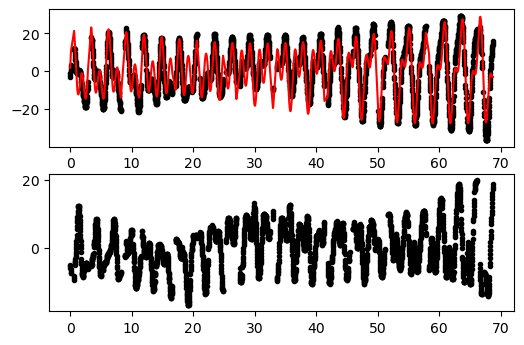

In [98]:
from scipy import optimize
import matplotlib.pyplot as plt

np.random.seed(0)

def f(t,p1,p2,amp1,amp2,amp3,amp4,phi1,phi2,phi3,phi4):

    model = amp1*np.sin(2*np.pi*1./p1*t  + phi1) + amp1*np.sin(2*np.pi*2/p1*t  + phi2)
    model += amp3*np.sin(2*np.pi*1./p2*t  + phi3) + amp4*np.sin(2*np.pi*2/p2*t  + phi4)
            
    return model

p0 = np.array([2.85, 2.95, 5, 5, 5, 5, 0, 0, 0, 0])

# Fit the model: the parameters omega and phi can be found in the
# `params` vector
params, params_cov = optimize.curve_fit(f, x, y, p0, method='lm')

print(params)

fig,(ax1,ax2) = plt.subplots(nrows=2,ncols=1)

ax1.plot(x, y, 'k.')
ax1.plot(x, f(x, *params), 'r-')
ax2.plot(x, y - f(x, *params), 'k.')
plt.show()

In [99]:
import pymc3 as pm
import aesara_theano_fallback.tensor as tt
import pymc3_ext as pmx

# Constant period model

In [100]:
#You can use the results from the non-linear least squares fit above to initialize our guess for the MAP.
#But those results don't actually looks so good.
#The optimization performed here seems to work well without this initialization.

def build_model(mask=None, start=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)
    with pm.Model() as model:

        # Sampled model parameters
        logp1 = pm.Normal("logp1", mu=np.log10(2.7), sd=1)
        logp2 = pm.Normal("logp2", mu=np.log10(2.8), sd=1)
        logp3 = pm.Normal("logp3", mu=np.log10(3.0), sd=1)
#         logp4 = pm.Normal("logp4", mu=np.log10(3.2), sd=1)
#         logp5 = pm.Normal("logp5", mu=np.log10(3.0), sd=1)
#         logp6 = pm.Normal("logp6", mu=np.log10(3.0), sd=1)

        amp1 = pm.Uniform("amp1", lower=-1000, upper=1000)
        amp2 = pm.Uniform("amp2", lower=-1000, upper=1000)
        amp3 = pm.Uniform("amp3", lower=-1000, upper=1000)

        amp4 = pm.Uniform("amp4", lower=-1000, upper=1000)
        amp5 = pm.Uniform("amp5", lower=-1000, upper=1000)
        amp6 = pm.Uniform("amp6", lower=-1000, upper=1000)
        
#         amp7 = pm.Uniform("amp7", lower=-1000, upper=1000)
#         amp8 = pm.Uniform("amp8", lower=-1000, upper=1000)
#         amp9 = pm.Uniform("amp9", lower=-1000, upper=1000)
        
#         amp10 = pm.Uniform("amp10", lower=-1000, upper=1000)
#         amp11 = pm.Uniform("amp11", lower=-1000, upper=1000)
#         amp12 = pm.Uniform("amp12", lower=-1000, upper=1000)

#         amp13 = pm.Uniform("amp13", lower=-1000, upper=1000)
#         amp14 = pm.Uniform("amp14", lower=-1000, upper=1000)
#         amp15 = pm.Uniform("amp15", lower=-1000, upper=1000)
        
#         amp16 = pm.Uniform("amp16", lower=-1000, upper=1000)
#         amp17 = pm.Uniform("amp17", lower=-1000, upper=1000)
#         amp18 = pm.Uniform("amp18", lower=-1000, upper=1000)
        
        phi1 = pm.Uniform("phi1", lower=0, upper=np.pi)
        phi2 = pm.Uniform("phi2", lower=0, upper=np.pi)
        phi3 = pm.Uniform("phi3", lower=0, upper=np.pi)
        phi4 = pm.Uniform("phi4", lower=0, upper=np.pi)
        phi5 = pm.Uniform("phi5", lower=0, upper=np.pi)
        phi6 = pm.Uniform("phi6", lower=0, upper=np.pi)
        
        # Deterministic parameters
        p1 = pm.Deterministic("p1", 10**logp1)
        p2 = pm.Deterministic("p2", 10**logp2)
        p3 = pm.Deterministic("p3", 10**logp3)
#         p4 = pm.Deterministic("p4", 10**logp4)
#         p5 = pm.Deterministic("p5", 10**logp5)
#         p6 = pm.Deterministic("p6", 10**logp6)
        
        f1 = pm.Deterministic("f1", 1./p1)
        f2 = pm.Deterministic("f2", 1./p2)
        f3 = pm.Deterministic("f3", 1./p3)
#         f4 = pm.Deterministic("f4", 1./p4)
#         f5 = pm.Deterministic("f5", 1./p5)
#         f6 = pm.Deterministic("f6", 1./p6)
                
        # Choose the degree of the polynomial trend for the background model
        deg = 5
        
        # Define the background model
        trend = pm.Normal(
        "trend", mu=0, sd=10.0 ** -np.arange(deg)[::-1], shape=deg)
    
        A = np.vander(x, deg)
        bkg = pm.Deterministic("bkg", tt.dot(A, trend))

        # Define the full light curve model
        lc_model = pm.Deterministic("lc_model",
                                    bkg +\
                                    amp1*tt.sin(2*np.pi*f1*x + phi1) +\
                                    amp2*tt.sin(4*np.pi*f1*x + phi2) +\
                                    amp3*tt.sin(2*np.pi*f2*x + phi3) +\
                                    amp4*tt.sin(4*np.pi*f2*x + phi4) +\
                                    amp5*tt.sin(2*np.pi*f3*x + phi5) +\
                                    amp6*tt.sin(4*np.pi*f3*x + phi6))
        
#         # Define the full light curve model
#         lc_model = pm.Deterministic("lc_model",
#                                     bkg +\
#                                     amp1*tt.sin(2*np.pi*f1*x + phi1) +\
#                                     amp2*tt.sin(4*np.pi*f1*x + phi1) +\
#                                     amp3*tt.sin(6*np.pi*f1*x + phi1) +\
#                                     amp4*tt.sin(2*np.pi*f2*x + phi2) +\
#                                     amp5*tt.sin(4*np.pi*f2*x + phi2) +\
#                                     amp6*tt.sin(6*np.pi*f2*x + phi2) +\
#                                     amp7*tt.sin(2*np.pi*f3*x + phi3) +\
#                                     amp8*tt.sin(4*np.pi*f3*x + phi3) +\
#                                     amp9*tt.sin(6*np.pi*f3*x + phi3) +\
#                                     amp10*tt.sin(2*np.pi*f4*x + phi4) +\
#                                     amp11*tt.sin(4*np.pi*f4*x + phi4) +\
#                                     amp12*tt.sin(6*np.pi*f4*x + phi4) +\
#                                     amp13*tt.sin(2*np.pi*f5*x + phi5) +\
#                                     amp14*tt.sin(4*np.pi*f5*x + phi5) +\
#                                     amp15*tt.sin(6*np.pi*f5*x + phi5) +\
#                                     amp16*tt.sin(2*np.pi*f6*x + phi6) +\
#                                     amp17*tt.sin(4*np.pi*f6*x + phi6) +\
#                                     amp18*tt.sin(6*np.pi*f6*x + phi6))
        
        
        # Eventually, you may want to solve for the photometric error.
        # Since the residuals from this simple mode are very non-Gaussian, this step may not work well at first.
        # The closer to get to describing the light curve, the better behaved the optimization for this parameter will be. 
        
        #logerr = pm.Normal("logerr", mu=np.log10(0.1), sd=1)
        #err = pm.Deterministic("err", 10**logerr)

        # The likelihood for the RVs
        pm.Normal("obs", mu=lc_model, sd=0.1, observed=y)        
                

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        map_soln = pmx.optimize(start=start, vars=[phi1])
        map_soln = pmx.optimize(start=map_soln, vars=[phi1,logp1,amp1,amp2])
        map_soln = pmx.optimize(start=map_soln, vars=[phi2,logp2,amp3,amp4])
        map_soln = pmx.optimize(start=map_soln, vars=[phi3,logp3,amp5,amp6])
        #map_soln = pmx.optimize(start=map_soln, vars=[phi4,logp4,amp7,amp8])
        #map_soln = pmx.optimize(start=map_soln, vars=[phi5,logp5,amp9,amp10])
        map_soln = pmx.optimize(start=map_soln)

    return model, map_soln


model0, map_soln0 = build_model()

optimizing logp for variables: [phi1]


message: Optimization terminated successfully.
logp: -25993016.707528796 -> -25993016.707528796
optimizing logp for variables: [amp2, amp1, logp1, phi1]


message: Desired error not necessarily achieved due to precision loss.
logp: -25993016.707528796 -> -23557675.32866469
optimizing logp for variables: [amp4, amp3, logp2, phi2]


message: Desired error not necessarily achieved due to precision loss.
logp: -23557675.32866469 -> -14429369.36542228
optimizing logp for variables: [amp6, amp5, logp3, phi3]


message: Desired error not necessarily achieved due to precision loss.
logp: -14429369.36542228 -> -12017034.515293933
optimizing logp for variables: [trend, phi6, phi5, phi4, phi3, phi2, phi1, amp6, amp5, amp4, amp3, amp2, amp1, logp3, logp2, logp1]


message: Desired error not necessarily achieved due to precision loss.
logp: -12017034.515293933 -> -910855.967837225


In [101]:
map_soln0

{'logp1': array(0.44095434),
 'logp2': array(0.45668262),
 'logp3': array(0.46142784),
 'amp1_interval__': array(-0.00514194),
 'amp2_interval__': array(-0.00137475),
 'amp3_interval__': array(-0.05770906),
 'amp4_interval__': array(0.00106101),
 'amp5_interval__': array(-0.03891769),
 'amp6_interval__': array(0.01506349),
 'phi1_interval__': array(13.03305243),
 'phi2_interval__': array(-8.83387357),
 'phi3_interval__': array(13.84169181),
 'phi4_interval__': array(-11.22107087),
 'phi5_interval__': array(-2.17073355),
 'phi6_interval__': array(-13.61735502),
 'trend': array([ 4.74836908e-06, -7.30240604e-04,  3.41031863e-02, -4.05746839e-01,
        -1.77564030e+00]),
 'amp1': array(-2.57096615),
 'amp2': array(-0.68737294),
 'amp3': array(-28.84652241),
 'amp4': array(0.53050706),
 'amp5': array(-19.4563912),
 'amp6': array(7.5316003),
 'phi1': array(3.14158578),
 'phi2': array(0.0004577),
 'phi3': array(3.14158959),
 'phi4': array(4.20624821e-05),
 'phi5': array(0.3217292),
 'phi6'

### A more compact model

In [107]:
def compact_model(mask=None, start=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)
    with pm.Model() as model:
        
        nper = 5
        
        
        # Sampled model parameters
        logps = pm.Normal("logps", mu=np.log10(3), sd=1, shape=nper, testval=[0.44095434,0.45668262,0.46142784,0.5,0.5])        
        amps  = pm.Uniform("amps", lower=-1000, upper=1000, shape=nper, testval=[-2.6,-28,-19,-1,-1])
        phis = pm.Uniform("phis", lower=0, upper=np.pi, shape=nper, testval=[3.,3.,0.32,0.3,0.3])
        
        hamps  = pm.Uniform("hamps", lower=-1000, upper=1000, shape=nper, testval=[-0.7,0.5,7.5,0.1,0.1])
        hphis = pm.Uniform("hphis", lower=0, upper=np.pi, shape=nper, testval=[0.01, 0.01, 0.01,0.01,0.01])
        
        # Deterministic parameters
        ps = pm.Deterministic("ps", 10**logps)
        fs = pm.Deterministic("fs", 1./ps)
                
        # Choose the degree of the polynomial trend for the background model
        deg = 5
        
        # Define the background model
        trend = pm.Normal(
        "trend", mu=0, sd=10.0 ** -np.arange(deg)[::-1], shape=deg)
    
        A = np.vander(x, deg)
        bkg = pm.Deterministic("bkg", tt.dot(A, trend))

        
        def spot_model(t, f, a, phi, ha, hphi):
            
            res = np.zeros(len(t))
            for i in range(nper):
                res += a[i]*tt.sin(2*np.pi*f[i]*t + phi[i])
                res += ha[i]*tt.sin(4*np.pi*f[i]*t + hphi[i])
            
            return res

        
        # Define the full light curve model
        lc_model = pm.Deterministic("lc_model",
                                    bkg +\
                                    spot_model(x, fs, amps, phis, hamps, phis))
        
        
        # Eventually, you may want to solve for the photometric error.
        # Since the residuals from this simple mode are very non-Gaussian, this step may not work well at first.
        # The closer to get to describing the light curve, the better behaved the optimization for this parameter will be. 
        
        #logerr = pm.Normal("logerr", mu=np.log10(0.1), sd=1)
        #err = pm.Deterministic("err", 10**logerr)

        # The likelihood for the RVs
        pm.Normal("obs", mu=lc_model, sd=0.1, observed=y)        
                

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        map_soln = pmx.optimize(start=start, vars=[phis, amps])
        map_soln = pmx.optimize(start=start, vars=[hphis, hamps])
        map_soln = pmx.optimize(start=map_soln, vars=[phis, logps, amps])
        map_soln = pmx.optimize(start=map_soln)

    return model, map_soln


model0, map_soln0 = compact_model()

optimizing logp for variables: [amps, phis]


message: Desired error not necessarily achieved due to precision loss.
logp: -3408671.1492006634 -> -1700500.7506803283
optimizing logp for variables: [hamps, hphis]


message: Desired error not necessarily achieved due to precision loss.
logp: -3408671.1492006634 -> -3166050.914918808
optimizing logp for variables: [amps, logps, phis]


message: Desired error not necessarily achieved due to precision loss.
logp: -3166050.914918808 -> -1305416.409458304
optimizing logp for variables: [trend, hphis, hamps, phis, amps, logps]


message: Desired error not necessarily achieved due to precision loss.
logp: -1305416.409458304 -> -701533.0606974248


### Print the MAP solution parameters

In [108]:
map_soln0

{'logps': array([0.44170955, 0.45797013, 0.46130854, 0.48066925, 0.46689524]),
 'amps_interval__': array([-0.00401406, -0.07629954, -0.06805828,  0.00145175,  0.01318853]),
 'phis_interval__': array([ 11.30782049,   9.95453874,  -3.94633144,  -9.23038476,
        -10.51840143]),
 'hamps_interval__': array([ 0.00132029, -0.00014482,  0.01548972, -0.00131537,  0.00275986]),
 'hphis_interval__': array([-5.46760770e-11, -5.46761056e-11, -5.46761117e-11, -5.46760849e-11,
        -5.46761242e-11]),
 'trend': array([ 6.37552717e-06, -9.53435419e-04,  4.43430802e-02, -5.85586072e-01,
        -7.20694046e-01]),
 'amps': array([ -2.00702917, -38.13127382, -34.01601083,   0.72587715,
          6.59416858]),
 'phis': array([3.14155409e+00, 3.14144340e+00, 5.95616922e-02, 3.07894647e-04,
        8.49286915e-05]),
 'hamps': array([ 0.66014472, -0.07241017,  7.7447076 , -0.65768401,  1.37992975]),
 'hphis': array([1.57079633, 1.57079633, 1.57079633, 1.57079633, 1.57079633]),
 'ps': array([2.76509175,

# Plot the MAP solution

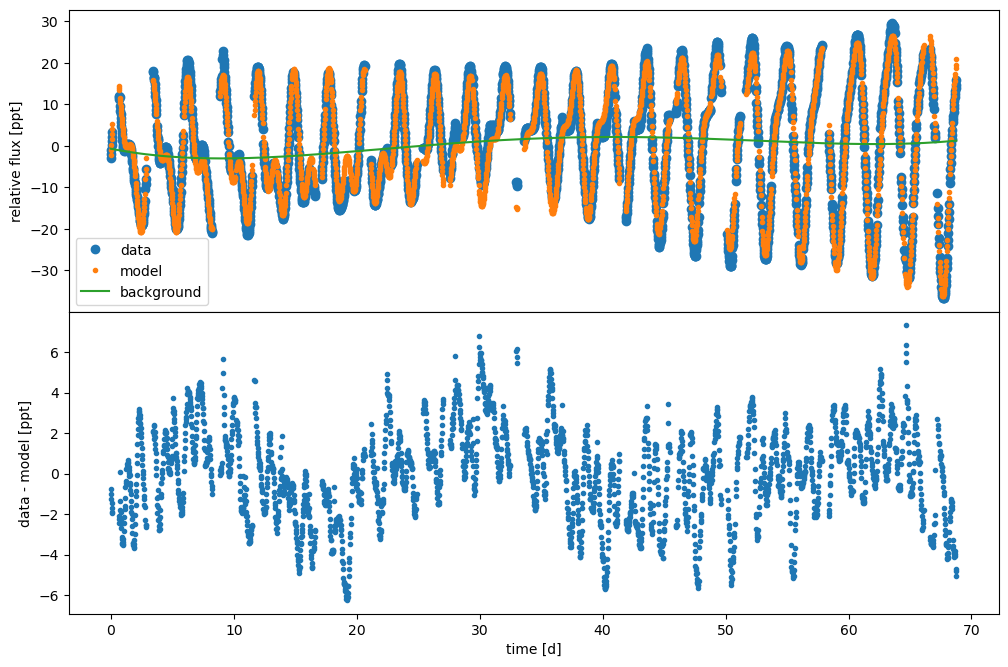

In [109]:
fig, (ax1,ax2) = plt.subplots(nrows=2,ncols=1,figsize=(12,8))

ax1.plot(x, y, 'o', label="data")
ax1.plot(x, map_soln0["lc_model"], '.', color='C1', label="model")
ax1.plot(x, map_soln0["bkg"], 'C2', label='background')
ax1.legend()
ax2.plot(x, y-map_soln0["lc_model"], '.')

ax1.set_ylabel("relative flux [ppt]")
ax2.set_ylabel("data - model [ppt]")
ax2.set_xlabel("time [d]")

plt.subplots_adjust(hspace=0)
plt.show()

## The fit is not great, but it's not so bad given the simplicity of the model. Let's take a closer look at the residuals. Maybe we missed some transits.

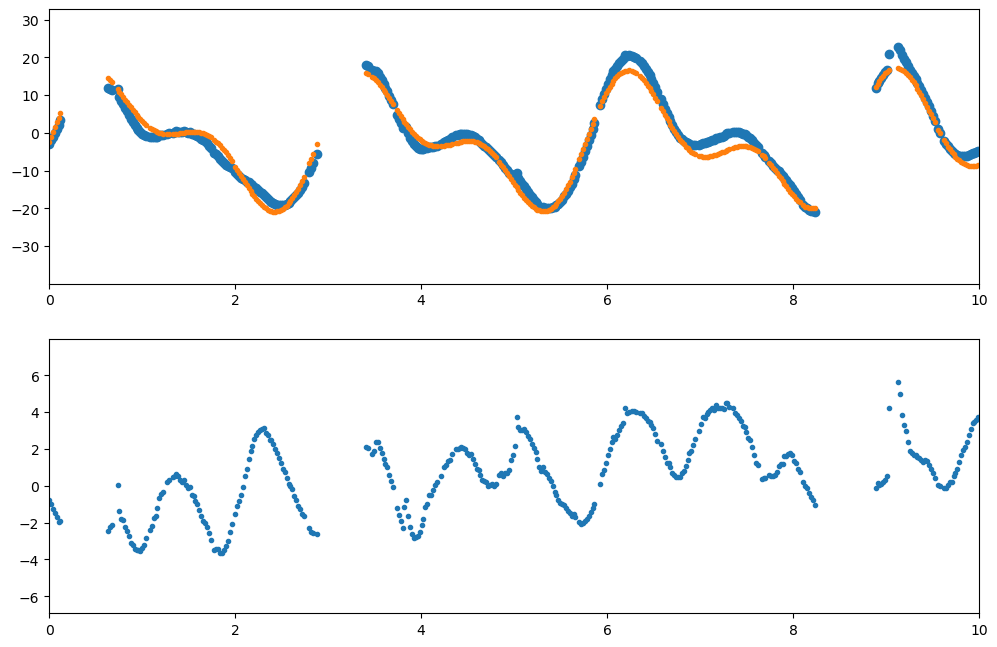

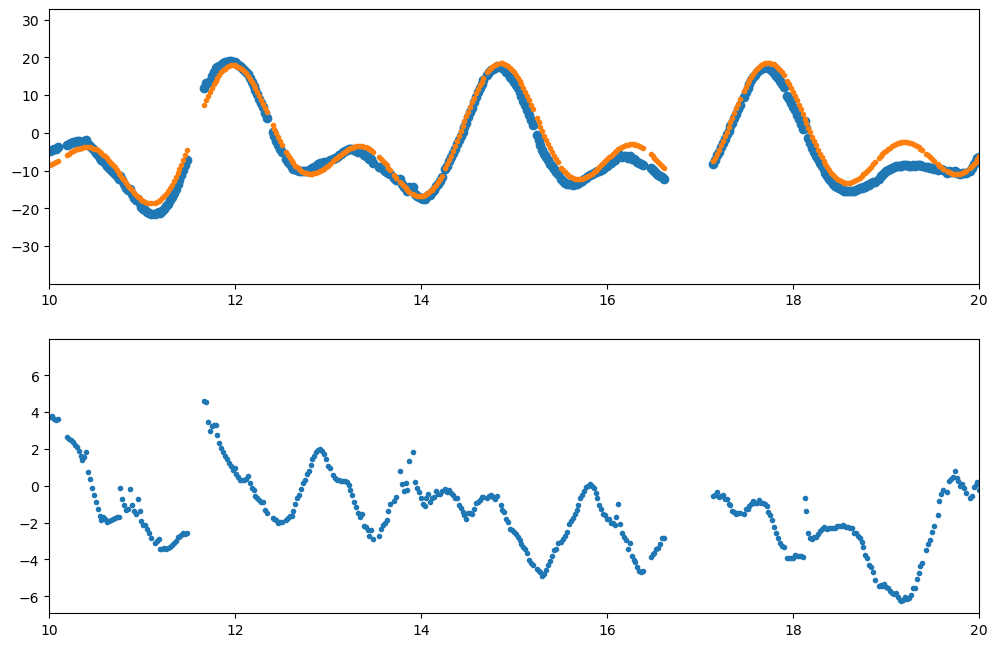

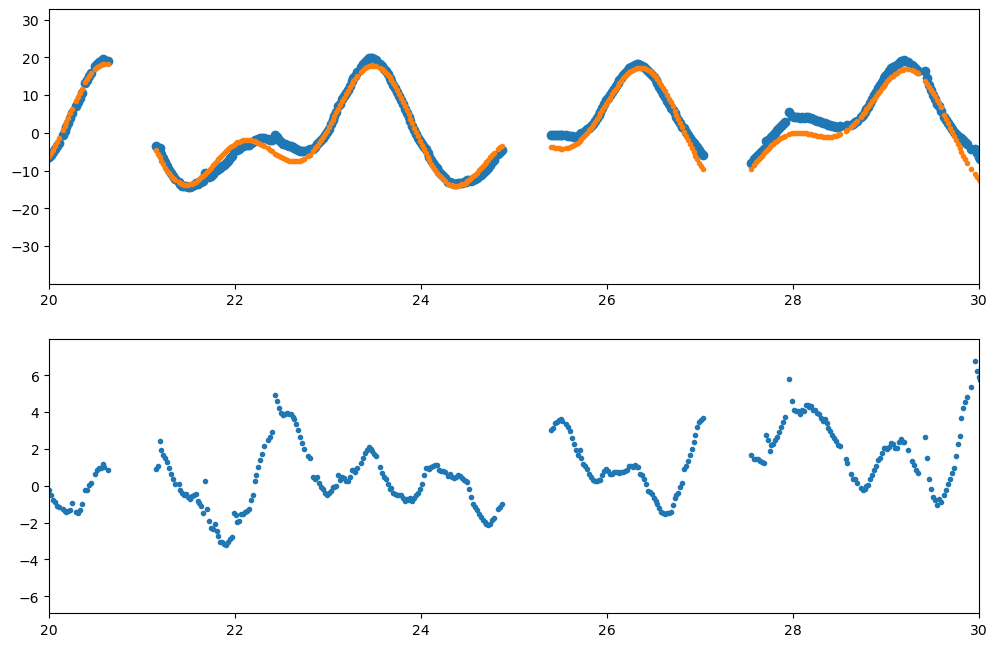

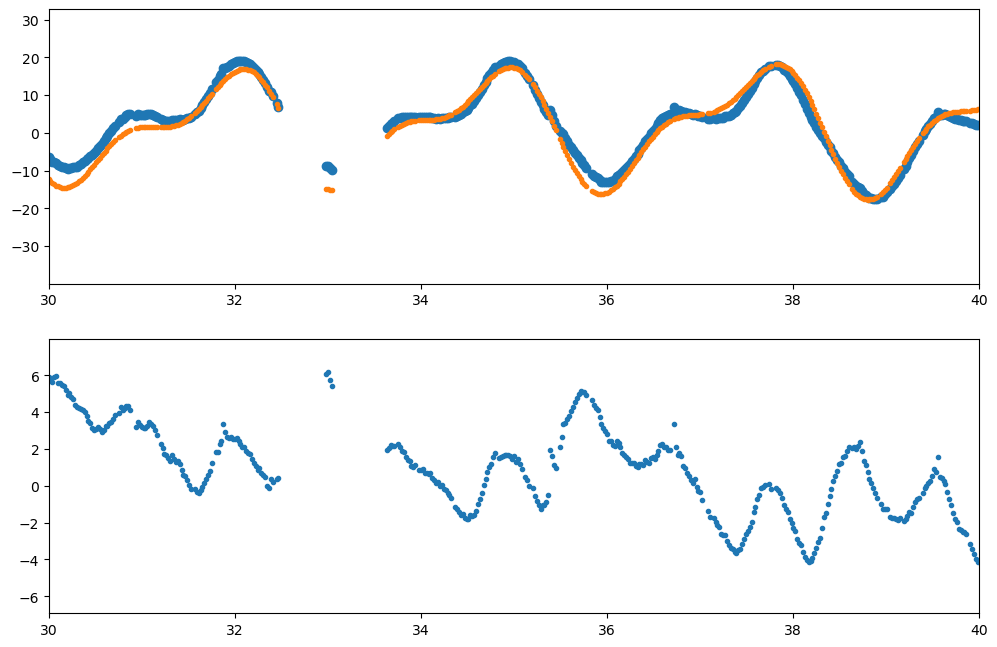

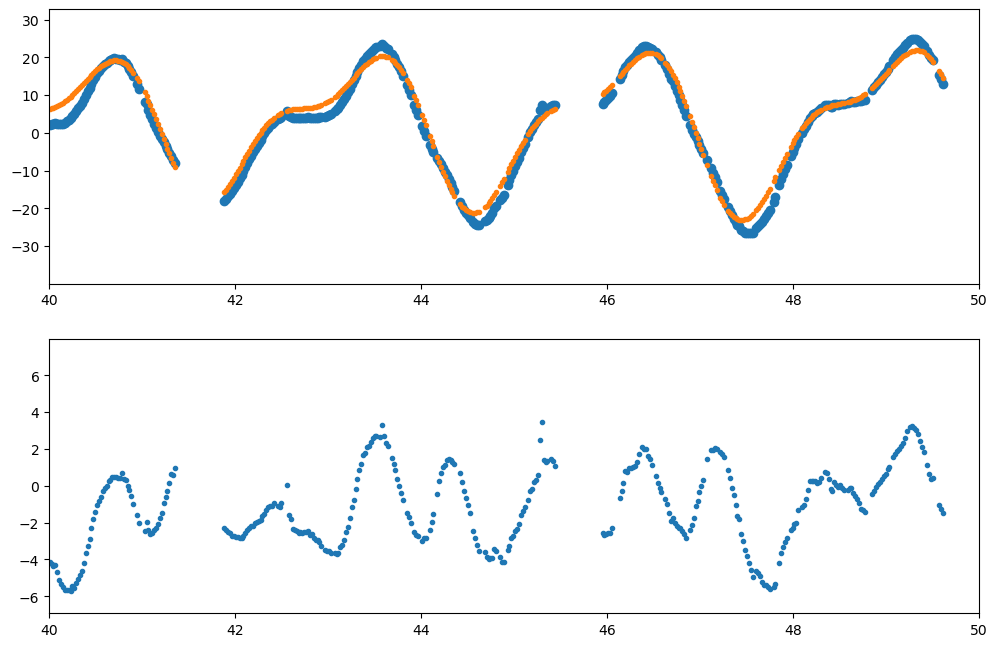

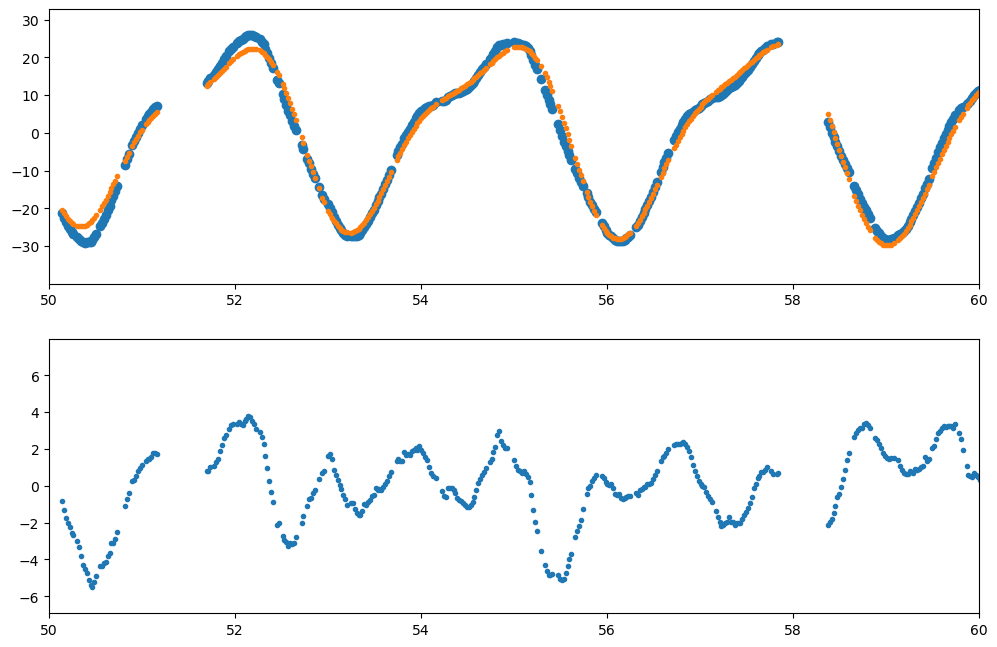

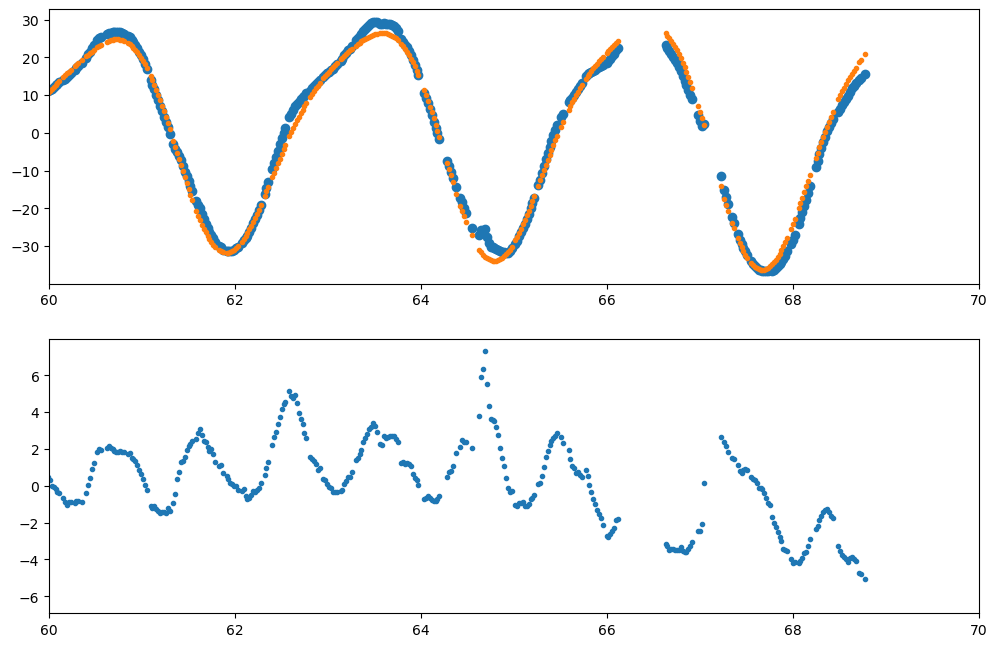

In [110]:
for i in range(7):
    
    fig, (ax1,ax2) = plt.subplots(nrows=2,ncols=1,figsize=(12,8))

    ax1.plot(x, y, 'o')
    ax1.plot(x, map_soln0["lc_model"], '.', color='C1')
    #ax1.plot(x, map_soln0["bkg"])
    ax2.plot(x, y-map_soln0["lc_model"], '.')
    
    ax1.set_xlim(i*10,(i+1)*10)
    ax2.set_xlim(i*10,(i+1)*10)

plt.show()

# Take a periodogram of the residuals

0.9559302629159783


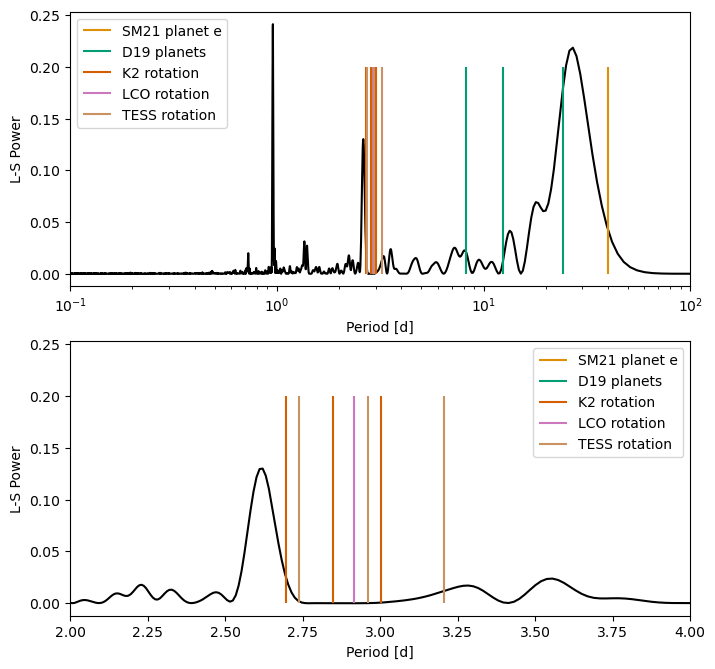

In [111]:
frequency, power = LombScargle(x, y-map_soln0["lc_model"], 
                               nterms=1).autopower(minimum_frequency=1/200,
                                               maximum_frequency=1/0.1,
                                               samples_per_peak=10)
period = 1/frequency

fig,(ax1,ax2) = plt.subplots(nrows=2,ncols=1,figsize=(8,8))

print(period[np.argmax(power)])

labels = ['SM21 planet e','D19 planets','K2 rotation', 'LCO rotation', 'TESS rotation']

for ax in [ax1,ax2]:

    ax.plot(period, power, 'k')

    for i,ps in enumerate([asm_period, planet_periods, k2_periods, lco_period, tess_periods]):
        ax.vlines(ps, ymin=0, ymax=0.2, color=colors[i+1], label=labels[i])

    ax.set_xlabel('Period [d]')
    ax.set_ylabel('L-S Power')
    ax.legend()

ax1.semilogx()
ax1.set_xlim(0.1,100)
ax2.set_xlim(2,4)
plt.show()

# Sampling

In [16]:
np.random.seed(42)
with model0:
    trace = pmx.sample(
        tune=1000,
        draws=1000,
        start=map_soln0,
        cores=2,
        chains=2,
        target_accept=0.9,
        return_inferencedata=True,
    )

KeyboardInterrupt: 

In [ ]:
import arviz as az

az.summary(
    trace,
    var_names=[
        "p1",
        "p2",
        "p3",
        "p4",
        "amp1",
        "amp2",
        "amp3",
        "amp4",
    ],
)

In [ ]:
flat_samps = trace.posterior.stack(sample=("chain", "draw"))

# Examine the period posteriors. Are any periods redundant?

In [ ]:
for i in range(1,5):
    plt.hist(flat_samps["p"+str(i)], histtype='step', bins=100, density=True, color=colors[i])
plt.xlabel("period [d]")    
plt.ylabel("probability density")    
plt.show()

# Examine the period-amplitude plane. Are some amplitudes so small as to contribute negligibly to the model?

In [ ]:
for i in range(1,5):
    plt.scatter(flat_samps["p"+str(i)], flat_samps["amp"+str(i)], color=colors[i])
    
plt.xlabel("period [d]")
plt.ylabel("amplitude [ppt]")
plt.show()

# It looks like only period #3 and its first harmonic are important. 
I explored models with only one fundamental period and power at the first, second, and third harmonics (w/ and without phase offsets) but these did not provide a good fit.

# Period (and amplitude) drift model
To simulate latitudinal migration of spots in the presence of differential surface rotation, we can allow each period to drift in time. Similarly, if you wanted to simulate the emergence and decay of spots (i.e. brightness evolution) you can allow the amplitudes to vary in time. In either case, start simple and assume period / amplitude are linear relations of time.

[ 2.87515445e+00  2.89611314e+00  5.57764259e+00  5.13797615e+00
 -5.93686394e-01  1.78183467e+01  1.32249734e+01 -6.17137656e-01
  1.92735095e+00 -2.69308892e-01  4.20377862e-01 -1.19476007e-01
  1.03764145e-02 -1.56467397e-01 -1.42499075e-01  9.25283363e-03
  1.53542220e-04 -1.67302337e-04]


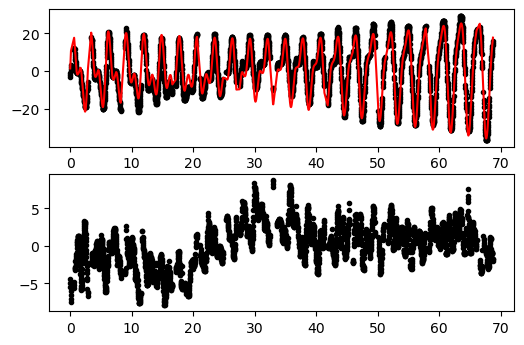

In [26]:
def f(t,p1,p2,amp1,amp2,amp3,amp4,amp5,amp6,phi1,phi2,adot1,adot2,adot3,adot4,adot5,adot6,pdot1,pdot2):

    A1 = (amp1+adot1*t)
    A2 = (amp2+adot2*t)
    A3 = (amp3+adot3*t)
    A4 = (amp4+adot4*t)    
    A5 = (amp5+adot5*t)
    A6 = (amp6+adot6*t)
    
    P1 = (p1 + pdot1*t)
    P2 = (p2 + pdot2*t)
    
    model = A1*np.sin(2*np.pi*1./P1*t  + phi1) + A2*np.sin(4*np.pi*1/P1*t  + phi1) + A3*np.sin(6*np.pi*2/P1*t  + phi1)
    model += A4*np.sin(2*np.pi*1./P2*t  + phi2) + A5*np.sin(2*np.pi*2/P2*t  + phi2) + A6*np.sin(6*np.pi*2/P2*t  + phi2) 
            
    return model


p0 = np.array([2.85, 2.95, 5, 5, 5, 5, 5, 5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0])

# Fit the model: the parameters omega and phi can be found in the
# `params` vector
params, params_cov = optimize.curve_fit(f, x, y, p0, method='lm')

print(params)

fig,(ax1,ax2) = plt.subplots(nrows=2,ncols=1)

ax1.plot(x, y, 'k.')
ax1.plot(x, f(x, *params), 'r-')
ax2.plot(x, y - f(x, *params), 'k.')
plt.show()

#### It's not pretty (there is surely a more compact way to write the function with a loop), but you can add these Adot and Pdot terms into the pymc3 model, and do some sampling to figure out if the data support either amplitude or period drift